In this note, I apply Random forest to the data set with binarized labels. Different cutoff values will be used to generate the ROC curve. Note that other apporahces, such as modifying the class_weight paramters (refer to sklearn documentation), can also be used. It is also noted that differnt extensions of ROC metric applied to multiclass classification problem can be found http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html .

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#from xgboost.sklearn import XGBClassifier

np.random.seed(0)

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import sklearn
import sklearn.grid_search
#from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

import math
from sklearn.metrics import confusion_matrix
from NDCG_score_func import ndcg_score
from __future__ import division

Loading X,y and X_test

In [2]:
X= np.load('X.npy')
y= np.load('y.npy')
X_test= np.load('X_test.npy')

In [3]:
y = y.astype(int)
y = np.equal(y, np.ones((len(y)))*7)
y = np.invert(y)
y = y.astype(int)
#booked-1; NDF-0

In [4]:
y

array([1, 1, 0, ..., 0, 1, 1])

Splitting data set into train and test sets

In [5]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X,y, \
                                   test_size=0.25, random_state=42)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(160088L, 226L)
(53363L, 226L)
(160088L,)
(53363L,)


### Random Forest
Fit random forest classifier with training set and test the performance on test set.

In [6]:
#Train random orest classier
clf = RandomForestClassifier(max_features=40,\
                             n_estimators=120, n_jobs=1,\
                             min_samples_split=5,class_weight = 'balanced')
                             #n_jobs=2 #, min_samples_split=5  max_features=12
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=40,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [7]:
#verifying prediction based on predict method and predict_proba method are the same:
my_prediction = (clf.predict_proba(X_test)[:,1]>0.5).astype(int)#convert boolean array to int array
(my_prediction == clf.predict(X_test).astype(int)).all()

True

Function __cutoff_predict__ that takes a trained classifier, a data matrix X, and a cutoff, and generates predictions based on the classifier's predicted probability and the cutoff value.

In [8]:
"""
cutoff_predict(clf, X, cutoff)

This function  takes a trained classifier, a data matrix X, and a cutoff, and 
generates predictions based on the classifier's predicted probability and the cutoff value.

Inputs:
clf: a **trained** classifier object
X: a 2D numpy array of features
cutoff: a float giving the cutoff value used to convert
        predicted probabilities into a 0/1 prediction.

Output:
a numpy array of 0/1 predictions.
"""
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)

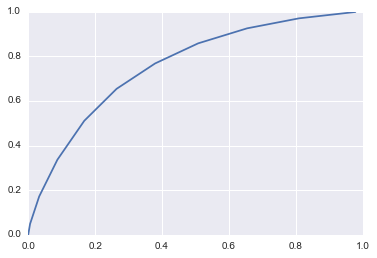

In [9]:
#Using differnet cutoff values and get the corresponding True possitive rate and False negtive rate
TPR_list=[]
FNR_list=[]
Accu_list=[]

for cutoff in np.arange(0, 1.1, 0.1):
# for cutoff in np.arange(0.5, 0.6, 0.1):
    cutoff_prediction = cutoff_predict(clf, X_test, cutoff)
    #y_test_pred = clf.predict(X_test)
    Labels = ['NDF','Booked']
    confusion= pd.DataFrame(data = confusion_matrix(y_test, cutoff_prediction),index = Labels, columns=Labels)
    TPR = confusion.loc['Booked','Booked']/confusion.loc['Booked'].sum()
    TPR_list.append(TPR)
    FNR = confusion.loc['NDF','Booked']/confusion.loc['NDF'].sum()
    FNR_list.append(FNR)
    Accu = (confusion.loc['Booked','Booked']+ confusion.loc['NDF','NDF'])/confusion.sum(axis=1).sum()
    Accu_list.append(Accu)

plt.plot(FNR_list, TPR_list)
plt.show()

Fig.1 False negtive rate vs. cutoff value for prediction.

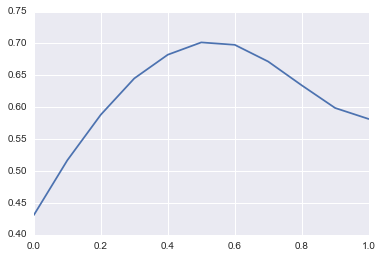

In [18]:
plt.plot(np.arange(0, 1.1, 0.1), Accu_list)
plt.show()

Fig.2 Accruacy vs. cutoff value for predition.

It can be see from the figure above that the optimum accuracy is achieved with threshold equal to 0.5. 